In [1]:
import sys
import re

!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install flashtext

from flashtext import KeywordProcessor
from scipy.spatial import distance
import networkx as nx

import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 1.6MB 499kB/s ta 0:00:01
  Found existing installation: decorator 4.1.2
    Uninstalling decorator-4.1.2:
      Successfully uninstalled decorator-4.1.2
You are using pip version 9.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for flashtext ... done
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext
You are using pip version 9.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Choosing data source 

In [2]:
# country choices: serbia, greece, portugal, germany, spain, cyprus, belgium, malta, all

country = 'portugal'
filename = f'glassdoor_{country}_de_jobs.csv'

In [3]:
all_dfs = {}
header = ["","Company name", "Degree Required", "Industry", "Job Description","Job Title","Level","Location","Rating","Salary Estimate","Sector","Size",]
df = pd.read_csv(filename, names=header)
df = df.drop([""], axis=1)
df['Company name'] = df.apply(lambda row: row['Company name'].split("\n")[0], axis = 1)
df['Job Description'] = df.apply(lambda row: row['Job Description'].replace("\n", " "), axis = 1)
df['Size From'] = df.apply(lambda row:  row['Size'].split(" ")[0] if isinstance(row['Size'], str) else np.nan, axis = 1)

df[:10]

Company name  Degree Required  \
0     BOLD by Devoteam             True   
1          Damia Group            False   
2      Springer Nature            False   
3              Tamanna             True   
4             KI Group             True   
5          Groupe BPCE            False   
6  Vestas Wind Systems             True   
7           Cloudflare             True   
8          Tripadvisor            False   
9          Bosch Group             True   

                                Industry  \
0                            IT Services   
1                 Staffing & Outsourcing   
2                             Publishing   
3                            IT Services   
4                                    NaN   
5                  Banks & Credit Unions   
6  Electrical & Electronic Manufacturing   
7                               Internet   
8                               Internet   
9            Miscellaneous Manufacturing   

                                     Job Description  \
0  The passion for what we do has no boundaries, ...   
1  Join SKY as a Data Engineer and you'll be part...   
2  Springer Nature opens the doors to discovery f...   
3  Are you ready for a real challenge? We're look...   
4  Are you ready for a real challenge? We're look...   
5  Informatique  Senior Data Engineer (m/f/div)  ...   
6  Data Engineer PT, Porto | Professional | Full-...   
7  About Us  At Cloudflare, we have our eyes set ...   
8  TripAdvisor, the world's largest travel site, ...   
9  Company Description  Welcome to Bosch  Cars dr...   

                                           Job Title   Level Location  Rating  \
0                                      Data Engineer     NaN   Lisbon     3.7   
1                                      Data Engineer  senior   Lisbon     3.8   
2                                      Data Engineer     NaN   Lisbon     3.3   
3                                      Data Engineer  middle   Lisbon     2.4   
4                                      Data Engineer  middle   Lisbon     4.6   
5                     Senior Data Engineer (m/f/div)  senior    Porto     3.7   
6                                      Data Engineer     NaN    Porto     3.5   
7               Systems Engineer - Data Intelligence     NaN   Lisbon     3.8   
8                 Data Engineer (Data Platform team)     NaN   Lisbon     3.5   
9  Data Science Engineer - Industry 4.0 Applications     NaN   Aveiro     4.0   

   Salary Estimate                  Sector                    Size Size From  
0              NaN  Information Technology   501 to 1000 Employees       501  
1              NaN       Business Services       1 to 50 Employees         1  
2              NaN                   Media        10000+ Employees    10000+  
3              NaN  Information Technology     51 to 200 Employees        51  
4              NaN                     NaN     51 to 200 Employees        51  
5              NaN                 Finance        10000+ Employees    10000+  
6              NaN           Manufacturing        10000+ Employees    10000+  
7              NaN  Information Technology  1001 to 5000 Employees      1001  
8              NaN  Information Technology  1001 to 5000 Employees      1001  
9              NaN           Manufacturing        10000+ Employees    10000+

## Industries

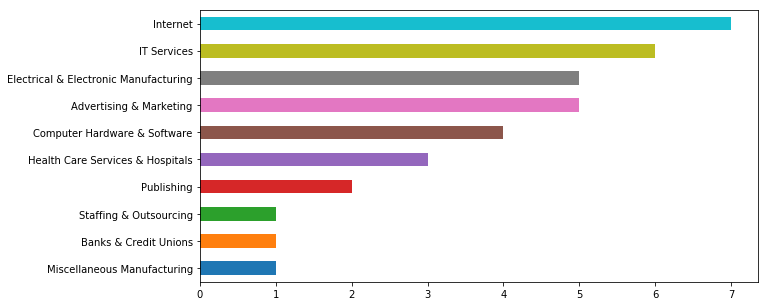

In [4]:
plt.figure(figsize=(10, df["Industry"].nunique()/2))
df["Industry"].value_counts().sort_values().plot(kind = 'barh')

## Cities

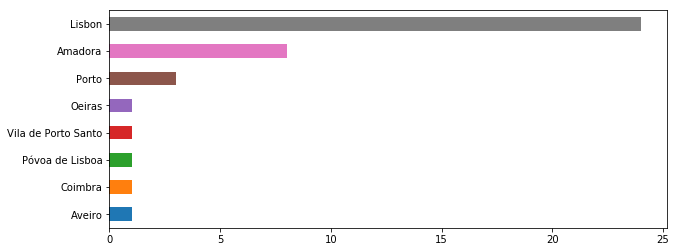

In [5]:
plt.figure(figsize=(10,df["Location"].nunique()/2))
df["Location"].value_counts().sort_values().plot(kind = 'barh')

## Company ratings

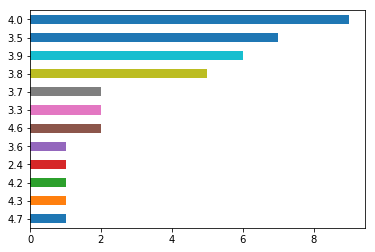

In [6]:
df["Rating"].value_counts().sort_values().plot(kind = 'barh')

## Company sizes

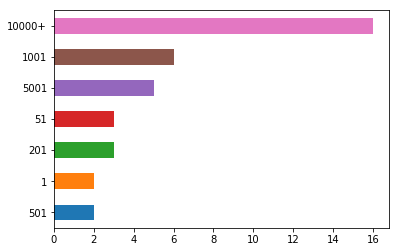

In [7]:
df["Size From"].value_counts().sort_values().plot(kind = 'barh')

In [8]:
if df["Salary Estimate"].value_counts().any():
    df["Salary Estimate"].value_counts().sort_values().plot(kind = 'barh')
else:
    print('No salaries data')
    
 #could not get salaries data from glassdoor, probably a bug

No salaries data


## Skill level

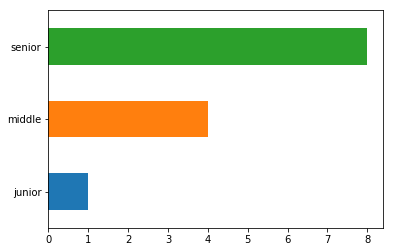

In [9]:
df["Level"].value_counts().sort_values().plot(kind = 'barh')

## Is an university degree required

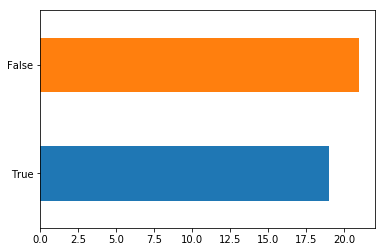

In [10]:
df["Degree Required"].value_counts().sort_values().plot(kind = 'barh')

## Technologies keywords in job descriptions

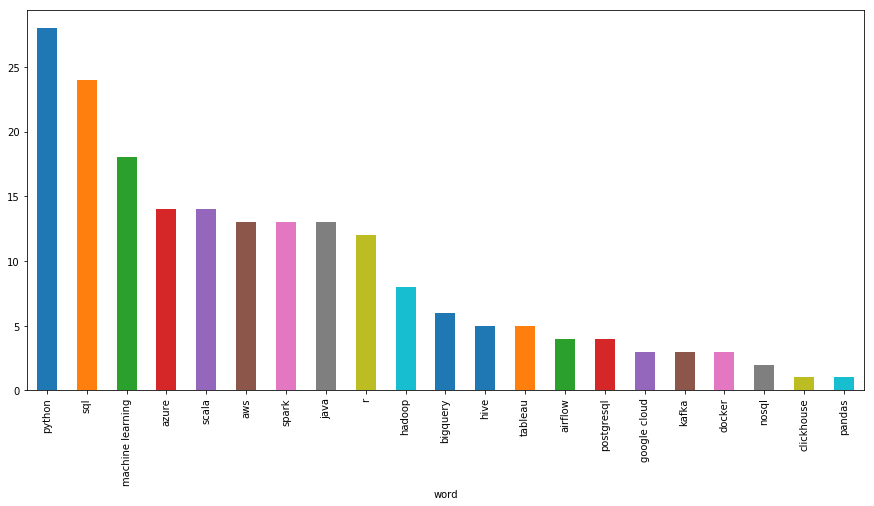

In [11]:
tech_keywords = ['hadoop', 'spark', 'aws','azure','gcp','nosql',
                 'postgresql','ml','sql','cassandra','python',
                 'r','java','scala','mapreduce','hive','airflow',
                 'hdfs','docker','dbt','tableau','vertica',
                 'bigquery', 'pandas', 'machine learning',
                 'pyspark', 'kafka', 'streamsets','clickhouse']


keyword_processor = KeywordProcessor()
keyword_processor.add_keywords_from_list(tech_keywords)
keyword_processor.add_keyword('gcp', 'google cloud')
keyword_processor.add_keyword('pyspark', 'spark')
keyword_processor.add_keyword('ml', 'machine learning')
keyword_processor.add_keyword('elastic search', 'elk')


word_cnt = {}
documents = []
existing_keywords = []
for index, row in df.iterrows():
    found_keywords = list(set(keyword_processor.extract_keywords(row['Job Description'])))
    for word in found_keywords:
        if word not in word_cnt:
            word_cnt[word] = 1
        else:
            word_cnt[word] += 1
    if found_keywords:
        documents.append(found_keywords)
        existing_keywords += found_keywords
        
existing_keywords = list(set(existing_keywords))
        
word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
word_cnt_df[['cnt']].describe()


word_cnt_df.sort_values(by='cnt', ascending=False).plot(kind='bar', x='word', y='cnt', figsize=(15,7), legend=False)
plt.show()

## Keyword coocurrencies
Code based on https://www.kaggle.com/itoeiji/simple-co-occurrence-network

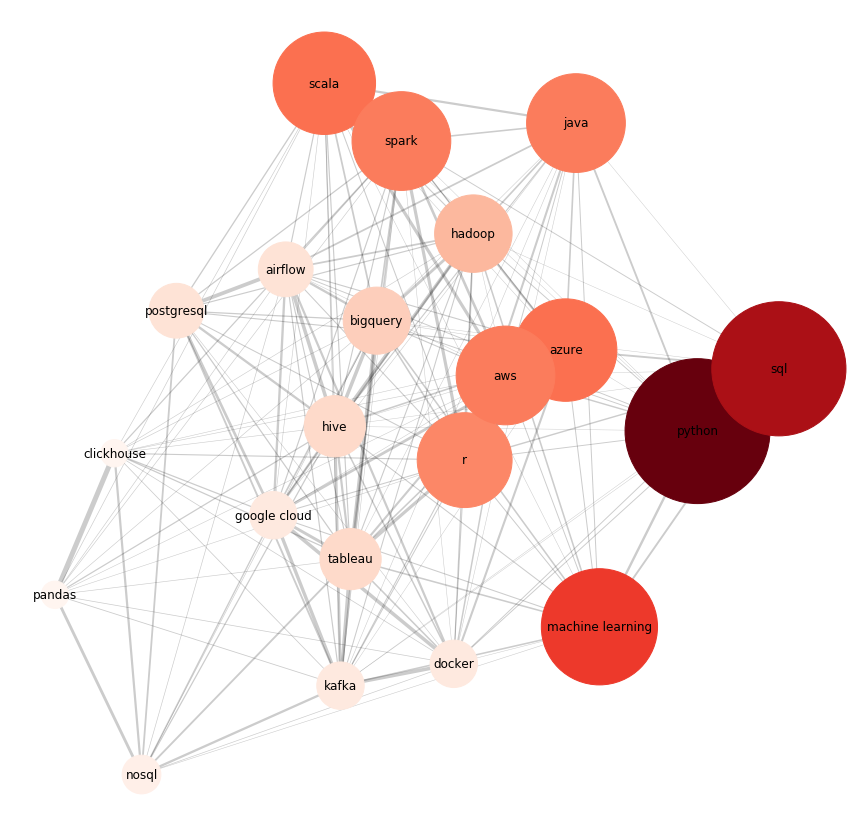

In [12]:


occurrences = OrderedDict((name, OrderedDict((name, 0) for name in existing_keywords)) for name in existing_keywords)

# Find the co-occurrences:
for l in documents:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1

combination_matrix = []

for name, values in occurrences.items():
    combination_matrix.append([i for i in values.values()])

combination_matrix = np.array(combination_matrix)

vocab = {}
target_words = word_cnt_df[word_cnt_df['cnt'] > 3]['word'].as_matrix()
for word in existing_keywords:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word

for i in range(len(existing_keywords)):
    combination_matrix[i, i] /= 2
        
# combination_matrix
jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')

nodes = []

for i in range(len(existing_keywords)):
    for j in range(i+1, len(existing_keywords)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])

G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.1)

node_size = [d['count']*750 for (n,d) in G.nodes(data=True)]
node_color = [d['count']*1 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, alpha=1, node_size=node_size, node_color=node_color, cmap=plt.cm.Reds)
nx.draw_networkx_labels(G, pos)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()